In [1]:
#load data
import os
mypath="C:/Users/USER/eRisk2017/2017/"
os.chdir( mypath )

In [2]:
import pandas as pd
import numpy as np

train_df=pd.read_csv('train_Depression_all_chunks_nosteem.csv')
train_df=train_df.replace(np.nan, '', regex=True)
test_df=pd.read_csv('test_Depression_all_chunks_nosteem.csv')
test_df=test_df.replace(np.nan, '', regex=True)

In [3]:
def generate_data(df, nchunks=1):
    # Extract the first chunk of data
    data = df['Chunk_1']
    
    # Rename the column to 'x' (although this line has no effect as it doesn't modify the original DataFrame)
#     data.rename(columns={'Chunk_1': 'x'})
    
    # If nchunks is less than or equal to 1, do nothing
    if nchunks <= 1:
        pass
    else:
        # Iterate over the remaining chunks and concatenate them with the first chunk
        for i in range(2, nchunks):
            chunk = 'Chunk_' + str(i)
            data += df[chunk]
    
    # Return the values of the concatenated data
    return data.values

In [4]:
#SVM_BOW
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
import time

In [5]:
def svm_bow(train, test, nChunks=1):

  # Generate data
  x_train = generate_data(train, nChunks)
  y_train = train['Depress'].values
  x_test = generate_data(test, nChunks)
  y_test = test['Depress'].values
 
  # Initialize classifier
  vectorizer = CountVectorizer(max_features=1000)
  clf = LinearSVC(tol=1e-5, C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
         intercept_scaling=1, loss='squared_hinge', max_iter=1000,
         multi_class='ovr', penalty='l2', random_state=1013, verbose=2)
  
  # Create bag of words
  X_train = vectorizer.fit_transform(x_train)
  X_test = vectorizer.transform(x_test)

  # Train the classifier
  clf.fit(X_train, y_train)

  # Predict on test data
  pred_test = clf.predict(X_test)

  # Calculate metrics
  accuracy = metrics.accuracy_score(y_test, pred_test)
  f1_score_weighted = metrics.f1_score(y_test, pred_test, average='weighted')
  recall_score = metrics.recall_score(y_test, pred_test, average='macro')
  
  my_metrics = [nChunks, accuracy, f1_score_weighted, recall_score]
  
  return [round(metric, 4) for metric in my_metrics]


In [6]:
bow_svm_metrics = np.zeros(shape=(10, 4))

for chunk in range(1, 11):
  tic = time.time()
  bow_svm_metrics[chunk - 1, :] = svm_bow(train_df, test_df, chunk)
  print('# Chunks: {} \t Processing Time (secs): {}'.format(chunk, time.time() - tic))


[LibLinear]# Chunks: 1 	 Processing Time (secs): 0.6355056762695312
[LibLinear]# Chunks: 2 	 Processing Time (secs): 0.6250452995300293
[LibLinear]# Chunks: 3 	 Processing Time (secs): 1.1399586200714111
[LibLinear]# Chunks: 4 	 Processing Time (secs): 2.067997932434082
[LibLinear]# Chunks: 5 	 Processing Time (secs): 3.4980037212371826
[LibLinear]# Chunks: 6 	 Processing Time (secs): 5.212288856506348
[LibLinear]# Chunks: 7 	 Processing Time (secs): 7.385998487472534
[LibLinear]# Chunks: 8 	 Processing Time (secs): 10.071006774902344
[LibLinear]# Chunks: 9 	 Processing Time (secs): 13.23078465461731
[LibLinear]# Chunks: 10 	 Processing Time (secs): 16.96524453163147


In [7]:
BowSVM_metrics=pd.DataFrame(bow_svm_metrics, columns=['Chunk','Acc','F1Score','Recall'])
BowSVM_metrics

,Chunk,Acc,F1Score,Recall
0,1.0,0.7930,0.8038,0.6029
1,2.0,0.7930,0.8038,0.6029
2,3.0,0.8105,0.8209,0.6456
3,4.0,0.8055,0.8150,0.6264
4,5.0,0.7955,0.8120,0.6534
5,6.0,0.8155,0.8245,0.6485
6,7.0,0.8180,0.8274,0.6581
7,8.0,0.8229,0.8311,0.6610
8,9.0,0.8180,0.8263,0.6499
9,10.0,0.8180,0.8252,0.6418


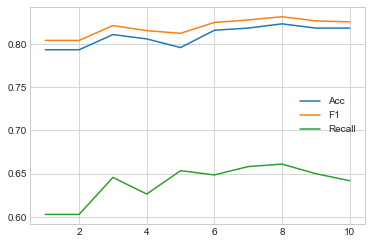

In [8]:
plt.style.use('seaborn-whitegrid')
plt.plot(BowSVM_metrics.Chunk,BowSVM_metrics.Acc, label='Acc')
plt.plot(BowSVM_metrics.Chunk,BowSVM_metrics.F1Score,label='F1')
plt.plot(BowSVM_metrics.Chunk,BowSVM_metrics.Recall,label='Recall')
plt.legend()

In [9]:
#SVM-Tf-Idf
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
def svm_tfidf(train, test, nChunks=1):

  # Generate data
  x_train = generate_data(train, nChunks)
  y_train = train['Depress'].values
  x_test = generate_data(test, nChunks)
  y_test = test['Depress'].values
 
  # Initialize classifier
  vectorizer = TfidfVectorizer(min_df=0.05, max_df=0.95)
  clf = LinearSVC(tol=1e-5, C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
         intercept_scaling=1, loss='squared_hinge', max_iter=1000,
         multi_class='ovr', penalty='l2', random_state=1013, verbose=2)
  
  # Perform Tf-Idf
  X_train = vectorizer.fit_transform(x_train)
  X_test = vectorizer.transform(x_test)

  # Train the classifier
  clf.fit(X_train, y_train)

  # Predict on test data
  pred_test = clf.predict(X_test)

  # Calculate metrics
  accuracy = metrics.accuracy_score(y_test, pred_test)
  f1_score_weighted = metrics.f1_score(y_test, pred_test, average='weighted')
  recall_score = metrics.recall_score(y_test, pred_test, average='macro')
  my_metrics = [nChunks, accuracy, f1_score_weighted, recall_score]
  
  return [round(metric, 4) for metric in my_metrics]


In [11]:
tfidf_svm_metrics = np.zeros(shape=(10, 4))

for chunk in range(1, 11):
  tic = time.time()
  tfidf_svm_metrics[chunk - 1, :] = svm_tfidf(train_df, test_df, chunk)
  print('Chunks: {} \t Processing Time (secs): {}'.format(chunk, time.time() - tic))


[LibLinear]Chunks: 1 	 Processing Time (secs): 16.00859045982361
[LibLinear]Chunks: 2 	 Processing Time (secs): 15.672680616378784
[LibLinear]Chunks: 3 	 Processing Time (secs): 16.22904086112976
[LibLinear]Chunks: 4 	 Processing Time (secs): 16.989007234573364
[LibLinear]Chunks: 5 	 Processing Time (secs): 18.00306725502014
[LibLinear]Chunks: 6 	 Processing Time (secs): 19.65404748916626
[LibLinear]Chunks: 7 	 Processing Time (secs): 21.779617071151733
[LibLinear]Chunks: 8 	 Processing Time (secs): 24.06241273880005
[LibLinear]Chunks: 9 	 Processing Time (secs): 26.844022274017334
[LibLinear]Chunks: 10 	 Processing Time (secs): 29.590008974075317


In [12]:
Tf_Idf_SVM=pd.DataFrame(tfidf_svm_metrics, columns=['Chunk','Acc','F1Score','Recall'])
Tf_Idf_SVM

,Chunk,Acc,F1Score,Recall
0,1.0,0.8803,0.8748,0.6939
1,2.0,0.8803,0.8748,0.6939
2,3.0,0.8803,0.8748,0.6939
3,4.0,0.8803,0.8748,0.6939
4,5.0,0.8803,0.8748,0.6939
5,6.0,0.8803,0.8748,0.6939
6,7.0,0.8803,0.8748,0.6939
7,8.0,0.8778,0.8715,0.6843
8,9.0,0.8778,0.8715,0.6843
9,10.0,0.8778,0.8715,0.6843


Text(0, 0.5, 'Rate')

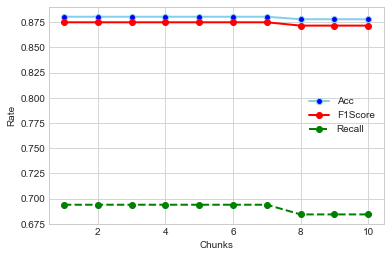

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# multiple line plot
plt.plot( 'Chunk', 'Acc', data=Tf_Idf_SVM, marker='o', markerfacecolor='blue' ,color='skyblue', linewidth=2)
plt.plot( 'Chunk', 'F1Score', data=Tf_Idf_SVM, marker='o', color='red', linewidth=2)
plt.plot( 'Chunk', 'Recall', data=Tf_Idf_SVM, marker='o', color='green', linewidth=2, linestyle='dashed')
plt.legend()
plt.xlabel("Chunks")
plt.ylabel("Rate")

In [1]:
#W2Vec-SVM (Google Embbeding)
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

C:\Users\USER\AppData\Roaming\Python\Python38\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
#Download google word2vec pretrained embedding 
#downloaded from kaggle https://www.kaggle.com/datasets/leadbest/googlenewsvectorsnegative300

In [ ]:
dirW2VGoogle =  "C:/Users/USER/archive/GoogleNews-vectors-negative300.bin.gz"
tic = time.time()
model_google = KeyedVectors.load_word2vec_format(dirW2VGoogle, binary=True)
print('Processing Time (secs): ', time.time() - tic)

In [ ]:
# obtain representations of google vectors
# def w2v_google(word,model=model_google):
#     if word not in model.vocab:
#         return 300*[0]
#     else:
#         return model[word]
def w2v_google(word, model=model_google, key_to_index=model_google.key_to_index):
    if word not in key_to_index:
        return 300 * [0]
    else:
        return model.get_vector(word)
# def w2v_google(word, model=model_google, key_to_index=model_google.key_to_index):
#     if word not in key_to_index:
#         return 300 * [0]
#     else:
#         return model.get_vector(word)

In [ ]:
# Given a number, returns its reciprocal. If the number is zero, returns zero.
def mydiag(x):
    if x==0:
        return (0)
    else:
        return (1/x)

In [ ]:
# import numpy as np
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.svm import LinearSVC
# from sklearn import metrics
# import time

def W2Vg_SVM(train, test, nChunks=1):
    # Generate data
    x_train = generate_data(train, nChunks)
    y_train = train['Depress'].values
    x_test = generate_data(test, nChunks)
    y_test = test['Depress'].values

    # Fit BoW
    vectorizer_bow = CountVectorizer(max_features=1000)
    BoW = vectorizer_bow.fit_transform(x_train)

    # Get vocabulary
    vocabulary = vectorizer_bow.vocabulary_

    # Container for word representations
    # The embedding has dimension 300, so we create a matrix of embeddings
    # with dimensions (#nVocab, 300)
    weight_google = np.empty((0, 300), float)

    # Get word representations (embedding matrix)
    for word in vocabulary:
        weight_google = np.vstack([weight_google, w2v_google(word)])

    # Training auxiliary: Get average representation of each document
    # based on the number of words using a linear combination with the embedding matrix
    DocTec = BoW.toarray()
    diag = np.diag(list(map(mydiag, DocTec.sum(axis=1))))

    # Training data
    X_train_google = diag @ DocTec @ weight_google

    # Test data
    Bow_test = vectorizer_bow.transform(x_test)
    DocTec_test = Bow_test.toarray()
    diag = np.diag(list(map(mydiag, DocTec_test.sum(axis=1))))
    X_test_google = diag @ DocTec_test @ weight_google

    # Initialize classifier
    clf_google = LinearSVC(tol=1e-5, C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
                           intercept_scaling=1, loss='squared_hinge', max_iter=1000,
                           multi_class='ovr', penalty='l2', random_state=1013, verbose=2)

    # Fit SVM-W2V-Google model
    clf_google.fit(X_train_google, y_train)

    # Predict on test data using Google embeddings
    pred_test_google = clf_google.predict(X_test_google)

    # Calculate metrics using Google embeddings
    acc_g = metrics.accuracy_score(y_test, pred_test_google)
    f1_score_g = metrics.f1_score(y_test, pred_test_google, average='weighted')
    recall_score_g = metrics.recall_score(y_test, pred_test_google, average='macro')

    metrics_g = [nChunks, acc_g, f1_score_g, recall_score_g]

    return [round(metric, 3) for metric in metrics_g]


w2v_svm_metrics = np.zeros(shape=(10, 4))

for chunk in range(1, 11):
    tic = time.time()
    w2v_svm_metrics[chunk - 1, :] = W2Vg_SVM(train_df, test_df, chunk)
    print('Chunks: {} \t Processing Time (secs): {}'.format(chunk, time.time() - tic))

In [ ]:
W2v_SVM=pd.DataFrame(w2v_svm_metrics, columns=['Chunks','Acc','F1Score','Recall'])
W2v_SVM

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# multiple line plot
plt.plot( 'Chunks', 'Acc', data=W2v_SVM, marker='v', color='cornflowerblue', linewidth=2)
plt.plot( 'Chunks', 'F1Score', data=W2v_SVM, marker='v', color='darkred', linewidth=2)
plt.plot( 'Chunks', 'Recall', data=W2v_SVM, marker='v', color='darkorange', linewidth=2)
plt.xlabel("Chunks")
plt.ylabel("Rate")
plt.legend()